# Detecting COVID-19 in Chest X-ray Images

<img src="misc/3D_medical_animation_coronavirus_structure.jpg" alt="Analysis of Corona Virus" style="width: 40%; height: 100%" align='left'/>

## Only for demonstration purposes!
This work was inspired by the following blog post: <br>
https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

As the author says:<br>
<i>The methods and techniques used in this post are meant for educational purposes only. This is not a scientifically rigorous study, nor will it be published in a journal.</i>

The same applies here.

# Data Load and Preparation for Training

In [1]:
# SAS Imports
from swat import CAS
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.lr_scheduler import *
from dlpy.splitting import two_way_split
from dlpy.metrics import accuracy_score, confusion_matrix, f1_score

# Open Source Imports
from random import sample
import onnx
import seaborn as sn

# Connect to SAS CAS
s = CAS('localhost', 5570, 'sas', 'Orion123')

In [2]:
# Setting paths
notebook_path = '/data/notebooks/deep_learning_examples/Covid19/'
path_to_covid_metadata = '/data/notebooks/deep_learning_examples/Covid19/covid-chestxray-dataset/metadata.csv'
path_to_covid_images = '/data/notebooks/deep_learning_examples/Covid19/covid-chestxray-dataset/images'
path_to_kaggle_images = '/data/notebooks/deep_learning_examples/Covid19/Chest X-Ray Images (Kaggle)/'

## Load Covid19 images 
Source: https://github.com/ieee8023/covid-chestxray-dataset

In [3]:
covid_chestxray = ImageTable.load_files(conn=s, 
                                        path=path_to_covid_images, 
                                        casout=dict(name='covid_chestxray'))
covid_chestxray.altertable(columns=[dict(name='_label_', drop=True),
                                    dict(name='_filename_0', rename='filename')])

# Read metadata csv into CAS Table
metadata = s.read_csv(filepath_or_buffer=path_to_covid_metadata, 
                      casout=dict(name='metadata', caslib='casuser', replace=True), 
                      usecols=list(range(0,16)))

# Combine images with metadata
s.loadactionset('deepLearn')
s.deepLearn.dlJoin(annotatedTable=metadata,
                   casOut={"name":"covid_joined_table"},
                   id="filename",
                   table=covid_chestxray
                  )
covid_joined = s.CASTable('covid_joined_table')
#covid_images = ImageTable.from_table(tbl=covid_joined, image_col='_image_', path_col='filename', columns=list(metadata.columns))
covid_images = ImageTable.from_table(tbl=covid_joined, columns=list(metadata.columns), casout=(dict(name='covid_images')))

# Filter only for COVID-19 findings
covid_images = covid_images[(covid_images['finding'].isin(['COVID-19'])) & (covid_images['view'] == 'PA')]
covid_images['_label_'] = 'Covid19'.ljust(13)

NOTE: Cloud Analytic Services made the uploaded file available as table METADATA in caslib CASUSER(sas).
NOTE: The table METADATA has been created in caslib CASUSER(sas) from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 'deepLearn'.


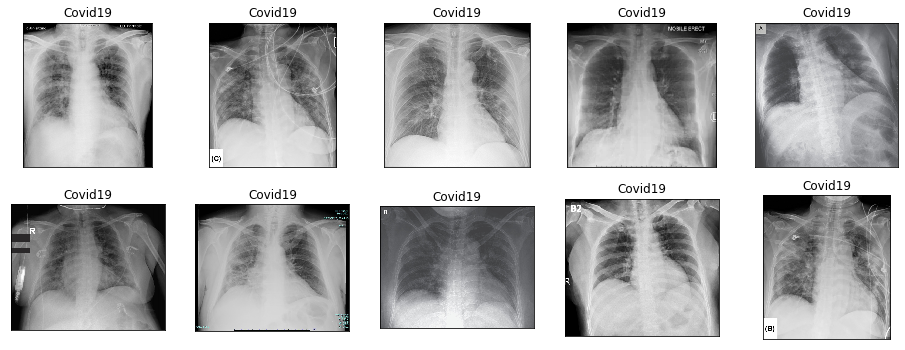

In [4]:
# How do our images look like?
covid_images.show(nimages=10, where=covid_images.params['where'], ncol=5)

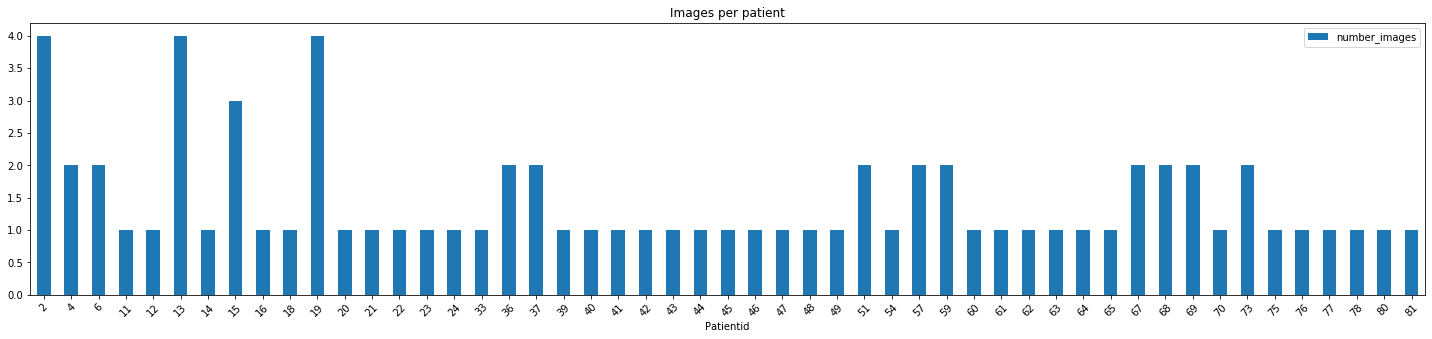

In [5]:
# How many images per patient? -> We see that sampling has to be done carefully because we have multiple images per patient 
images_per_patient = covid_images[['Patientid','_image_']].groupby(by='Patientid', sort=True).count().reset_index()[['Patientid', '_image_']].rename(columns={'_image_':'number_images'})
images_per_patient["Patientid"] = images_per_patient["Patientid"].astype(int)
images_per_patient = images_per_patient.sort_values('Patientid')
ax = images_per_patient.plot.bar(x='Patientid', y='number_images', rot=45, figsize=(25,5), title='Images per patient')

In [6]:
# Sample image tables by Patientid (make sure images from one patient are either train or test, not both)
patient_list = list(set(covid_images['Patientid'].values)) #list of patients
patients_covid19_train = sample(patient_list, int(len(patient_list)*0.9)) # 90% training dara
patients_covid19_test = list(set(patient_list) - set(patients_covid19_train)) # 10% rest for test data
covid_images_train = covid_images[covid_images['Patientid'].isin(patients_covid19_train)]
covid_images_test = covid_images[covid_images['Patientid'].isin(patients_covid19_test)]

## Load images of healthy persons
Source: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [7]:
# Load a sample of kaggle images and assign target = healthy 
kaggle_chestxray = ImageTable.load_files(conn=s, 
                                        path=path_to_kaggle_images, 
                                        casout=dict(name='kaggle_chestxray'))
kaggle_chestxray = ImageTable.from_table(tbl=kaggle_chestxray.sample(80)) # Number of healthy images from Kaggle
kaggle_chestxray.altertable(columns=[dict(name='_label_', drop=True)])
kaggle_chestxray['_label_'] = 'healthy'.ljust(13)
# Split Kaggle images into train/test
kaggle_chestxray_train, kaggle_chestxray_test = two_way_split(kaggle_chestxray, test_rate=10)

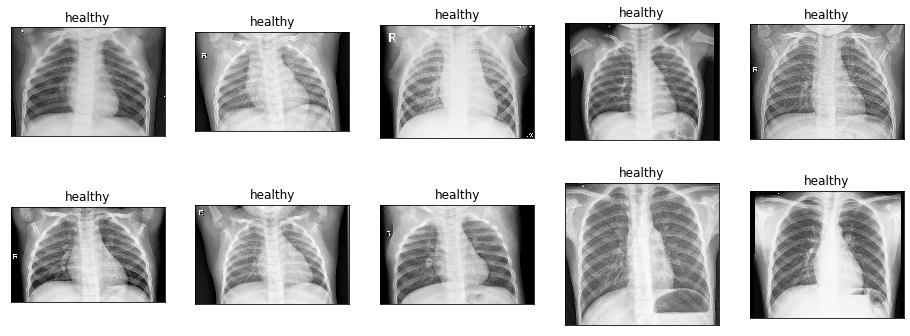

In [8]:
# How do our images look like?
kaggle_chestxray_train.show(nimages=10, ncol=5)

## Join Covid images and images of healthy persons

In [9]:
# Join COVID images with Kaggle data
s.dljoin(
        annotatedTable = covid_images_train,
        table = kaggle_chestxray_train,
        casout = {'name':'trainTbl','replace':True},
        id = 'idjoin',
        type = 'append'
    )
full_train = s.CASTable('trainTbl')
full_train = ImageTable.from_table(tbl=full_train, columns=list(full_train.columns)[4:])
s.dljoin(
        annotatedTable = covid_images_test,
        table = kaggle_chestxray_test,
        casout = {'name':'testTbl','replace':True},
        id = 'idjoin',
        type = 'append'
    )
full_test = s.CASTable('testTbl')
full_test = ImageTable.from_table(tbl=full_test, columns=list(full_test.columns)[4:])

In [10]:
# Resize and shuffle data
full_train.resize(height=224, width=224, columns=list(full_train.columns))
full_train.shuffle(casout=dict(replace=True))
full_test.resize(height=224, width=224, columns=list(full_test.columns))
full_test.shuffle(casout=dict(replace=True))

[caslib]

 'CASUSER(sas)'

[tableName]

 '_T_LS3H5M4R_L6GUWSI3_JVOIN2KK4G'

[casTable]

 CASTable('_T_LS3H5M4R_L6GUWSI3_JVOIN2KK4G', caslib='CASUSER(sas)')

+ Elapsed: 0.00301s, user: 0.005s, sys: 0.000327s, mem: 21.4mb

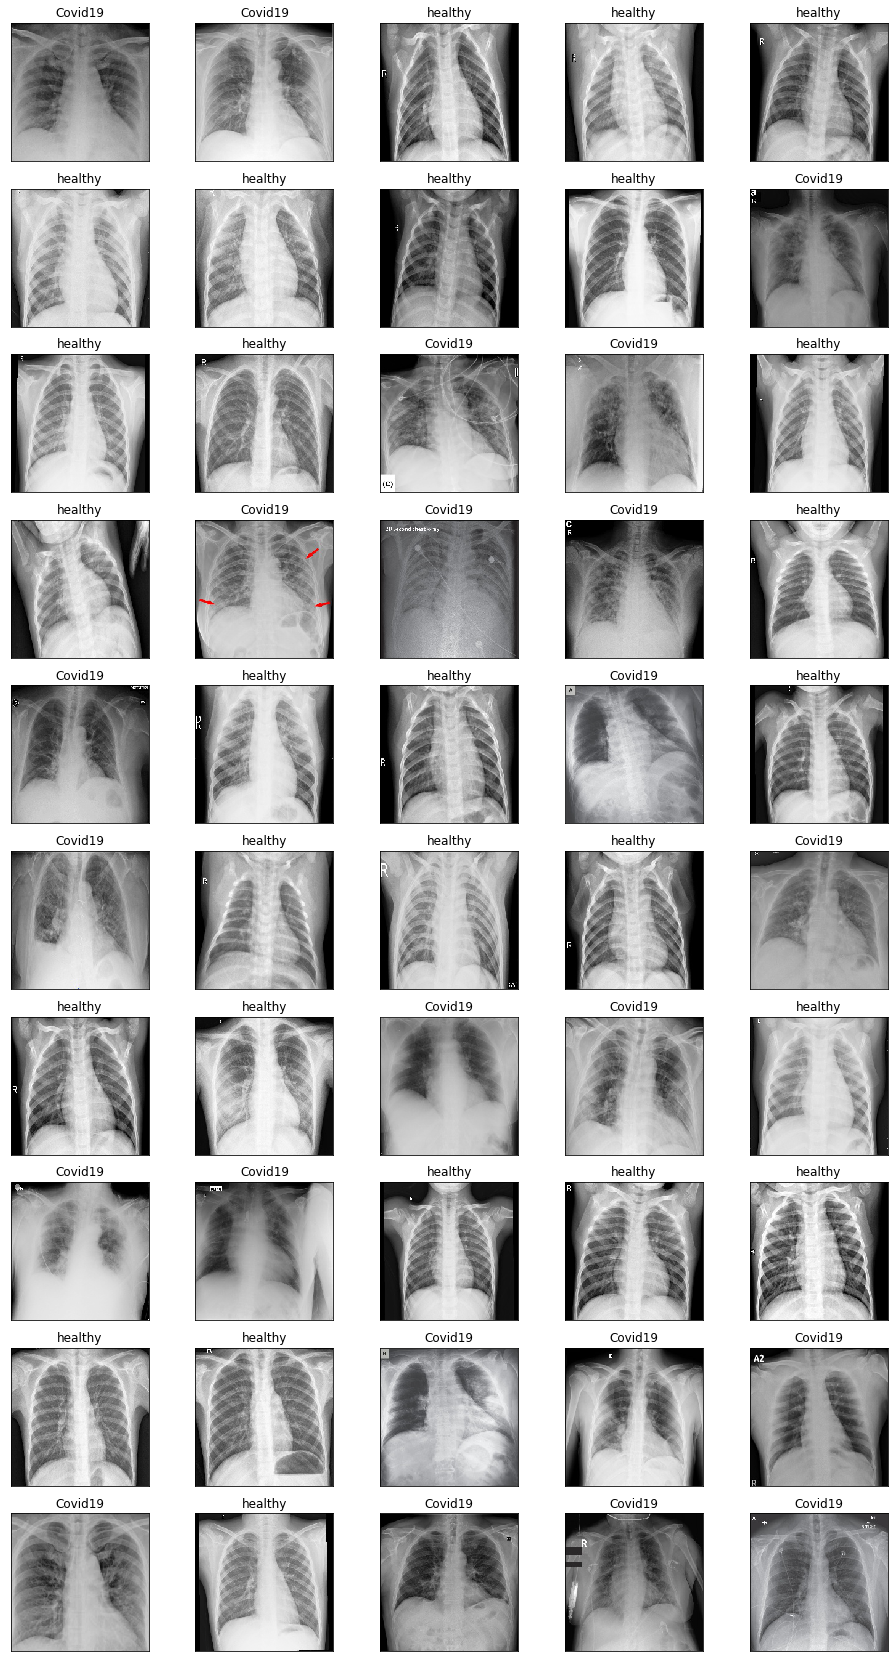

In [11]:
# How do our images look like?
full_train.show(nimages=50, ncol=5)

## Class distribution in training and testing dataset

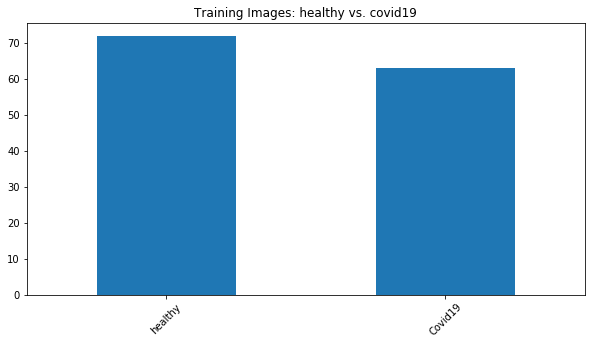

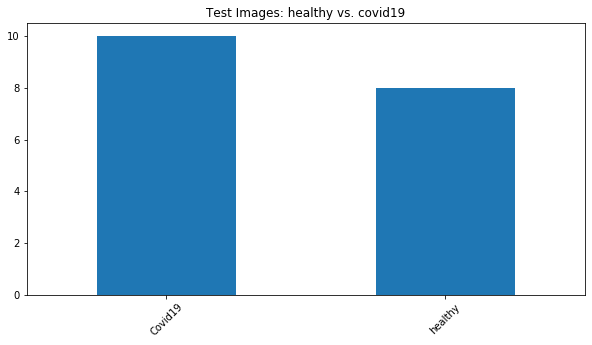

In [12]:
# Plot class distributions
fig, ax = plt.subplots()
full_train['_label_'].value_counts().plot(ax=ax, kind='bar', rot=45, title='Training Images: healthy vs. covid19', figsize=(10,5))
fig, ax = plt.subplots()
full_test['_label_'].value_counts().plot(ax=ax, kind='bar', rot=45, title='Test Images: healthy vs. covid19', figsize=(10,5))

## What we see during data loading and preparation
Some patients have multiple images taken. Therefore we want to make sure that images of the same patient are either in our training set or in the testing set.<br>
Additionally I sampled 80 images from the Kaggle dataset to have a more or less even distribution between healthy and infected patients

# Modelling

We will make use of transfer-learning and use a simple pretrained ResNet-50 Model which we'll adjust to our needs.<br>
The model can be downloaded here: https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v1/resnet50v1.onnx

In [13]:
# Load Resnet-50 ONNX model with pretrained weights
resnet_onnx_model_path = '/data/notebooks/deep_learning_examples/models/ONNX/resnet50/resnet50v1.onnx'
num_classes = len(set(full_train['_label_'].values))

onnx_model = onnx.load_model(resnet_onnx_model_path)
model = Model.from_onnx_model(s, 
                               onnx_model,
                               output_model_table='resnet50v1',
                               scale=1./255., 
                               offsets=[0.485, 0.456, 0.406])
# Remove last layer and add new layer with 2 classes (covid/healthy)
model_table = s.CASTable(model.model_table['name'])
model.load_weights(path='{}/resnet50v1_weights.onnxmodel.h5'.format(notebook_path))
model._retrieve_('deeplearn.removelayer', model=model_table, name='resnetv17_dense0_fwd')
model._retrieve_('deeplearn.addlayer', model=model_table, name='output',
                 layer=dict(type='output', n=num_classes, act='softmax'),
                 srcLayers=['resnetv17_pool1_fwd'])
weight_table_options = model.model_weights.to_table_params()
weight_table_options.update(dict(where='_LayerID_<125'))
model._retrieve_('table.partition', table=weight_table_options,
                 casout=dict(replace=True, **model.model_weights.to_table_params()))
model = Model.from_table(model_table)

NOTE: Successfully written weights file as /data/notebooks/deep_learning_examples/Covid19/resnet50v1_weights.onnxmodel.h5
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1" according to the model name in the table.
NOTE: Successfully imported ONNX model.
NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1" according to the model name in the table.


In [14]:
# Define training-parameters
lr_scheduler = ReduceLROnPlateau(conn=s, 
                                 cool_down_iters=10, 
                                 gamma=0.1, 
                                 learning_rate=0.01, 
                                 patience=15)
solver = MomentumSolver(momentum=0.9, 
                        lr_scheduler=lr_scheduler, 
                        clip_grad_max=100, 
                        clip_grad_min=-100)
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=8, 
                      log_level=2, 
                      max_epochs=100, 
                      reg_l2=0.0005,
                      stagnation=10,
                      bn_src_layer_warnings=False)

gpu = Gpu(devices=[0])

dataspecs=[dict(type='image', layer='data', data=['_image_']),
           dict(type='numnom', layer='output', data=['_label_'])]

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [15]:
# Start Training
model.fit(data=full_train,
          valid_table=full_test,
          optimizer=optimizer,
          data_specs=dataspecs, 
          n_threads=1, 
          record_seed=54321,
          force_equal_padding=True, 
          gpu=gpu,
          save_best_weights=True)

NOTE: Training based on existing weights.
NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 23531010.
NOTE:  The approximate memory cost is 527.00 MB.
NOTE:  Loading weights cost       0.52 (s).
NOTE:  Initializing each layer cost       3.84 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 8.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Covid19      
NOTE:  Level      1: healthy      
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0          0.01          0.3452     0.1324           0.3385        

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name                    resnet50v1
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                           126
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             1
 5              Number of Convolutional Layers                            53
 6                    Number of Pooling Layers                             2
 7            Number of Fully Connected Layers                             0
 8        Number of Batch Normalization Layers                            53
 9                   Number of Residual Layers                            16
 10                Number of Weight Parameters                      23459008
 11                  Number of Bias Parameters                         72002
 12           Total Number of Model Parameters                      23531010
 13  Approximate Memory Cost for Training (MB)                           527

[OptIterHistory]

     Epoch  LearningRate      Loss  FitError    L2Norm  ValidLoss  ValidError
 0       1         0.010  0.345155  0.132353  2.954334   0.338464    0.166667
 1       2         0.010  0.398365  0.080882  2.964872   0.607997    0.166667
 2       3         0.010  0.662806  0.132353  2.985605  10.233711    0.444444
 3       4         0.010  0.250320  0.088235  2.999123   1.018155    0.166667
 4       5         0.010  0.477144  0.117647  2.997132   5.078248    0.444444
 5       6         0.010  0.228838  0.088235  2.990481   2.502795    0.166667
 6       7         0.010  0.345303  0.095588  2.982353   0.489712    0.166667
 7       8         0.010  0.159159  0.029412  2.973446   0.076256    0.055556
 8       9         0.010  0.085887  0.029412  2.963824   0.067535    0.000000
 9      10         0.010  0.083782  0.014706  2.954083   0.071152    0.055556
 10     11         0.010  0.014793  0.000000  2.944258   0.065197    0.055556
 11     12         0.010  0.005362  0.000000  2.934364   0.062141    0.055556
 12     13         0.010  0.007490  0.000000  2.924459   0.031842    0.000000
 13     14         0.010  0.003297  0.000000  2.914570   0.056138    0.055556
 14     15         0.010  0.277334  0.058824  2.904847   0.083936    0.055556
 15     16         0.010  0.175014  0.036765  2.895417   0.065130    0.000000
 16     17         0.010  0.042191  0.014706  2.886001   0.037011    0.000000
 17     18         0.010  0.042981  0.007353  2.876500   0.019811    0.000000
 18     19         0.010  0.343114  0.051471  2.866994   0.459079    0.111111
 19     20         0.010  0.060619  0.051471  2.858219   0.132963    0.055556
 20     21         0.010  0.516564  0.058824  2.849243   0.007855    0.000000
 21     22         0.010  0.287963  0.088235  2.842110   1.555229    0.444444
 22     23         0.010  0.237217  0.080882  2.836504   6.250541    0.444444
 23     24         0.010  0.215361  0.058824  2.829612   0.418322    0.166667
 24     25         0.010  0.083167  0.029412  2.821591   0.318646    0.166667
 25     26         0.010  0.155155  0.051471  2.812915   0.956804    0.111111
 26     27         0.010  0.031121  0.014706  2.804416   0.057495    0.000000
 27     28         0.010  0.015216  0.000000  2.795482   0.038495    0.000000
 28     29         0.010  0.047839  0.014706  2.786202   0.081085    0.055556
 29     30         0.010  0.042910  0.014706  2.776867   0.056535    0.055556
 30     31         0.001  0.021689  0.014706  2.769211   0.006515    0.000000
 31     32         0.001  0.038302  0.014706  2.766471   0.008450    0.000000
 32     33         0.001  0.035087  0.007353  2.765234   0.013251    0.000000
 33     34         0.001  0.002180  0.000000  2.764246   0.013204    0.000000
 34     35         0.001  0.036975  0.007353  2.763301   0.010913    0.000000
 35  

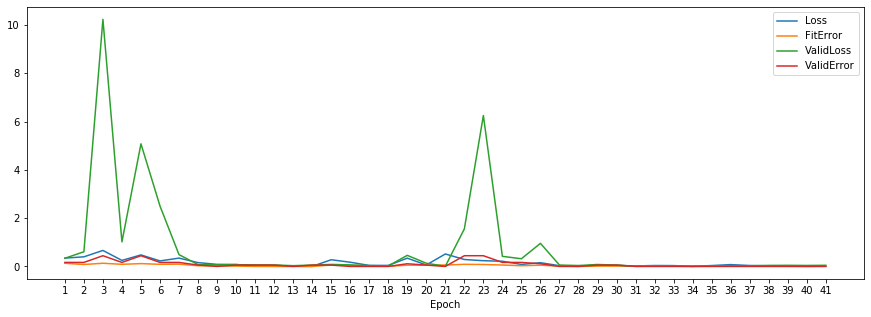

In [16]:
# View Training history
model.plot_training_history(items=['Loss','FitError','ValidLoss','ValidError'], fig_size=(15, 5))

In [17]:
model.evaluate(full_test)

NOTE: Due to data distribution, miniBatchSize has been limited to 2.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            18
 1  Number of Observations Used            18
 2  Misclassification Error (%)             0
 3                   Loss Error      0.048083

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_kN3Zfe    18       29   
 
                                             casTable  
 0  CASTable('Valid_Res_kN3Zfe', caslib='CASUSER(s...  

+ Elapsed: 1.28s, user: 8.72s, sys: 1.6s, mem: 2.87e+03mb

In [18]:
print('Accuracy: {} %'.format(accuracy_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])*100))
print('F1 Score: {}'.format(f1_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'], pos_label=1)))

Accuracy: 100.0 %
F1 Score: 1.0


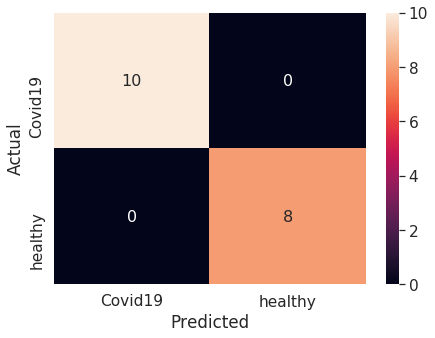

In [19]:
# Get confusion matrix heatmap
cfm_full = confusion_matrix(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])
cfm_full.index.name = 'Actual'
cfm_full.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)
sn.heatmap(cfm_full, annot=True, annot_kws={'size':16})

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


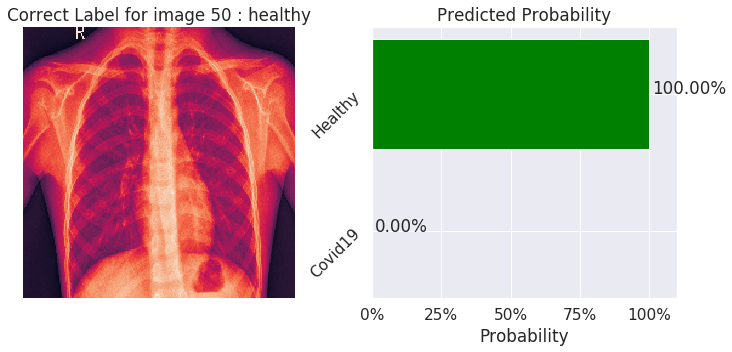

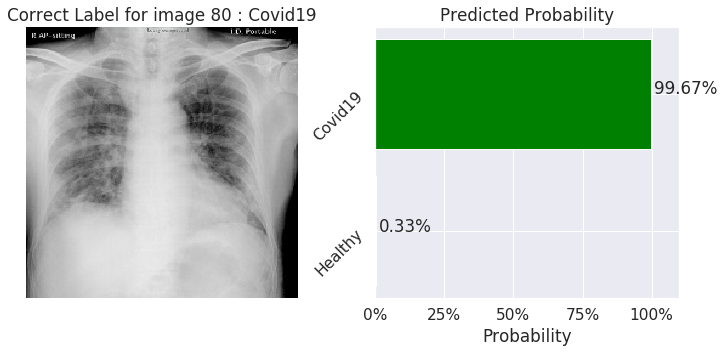

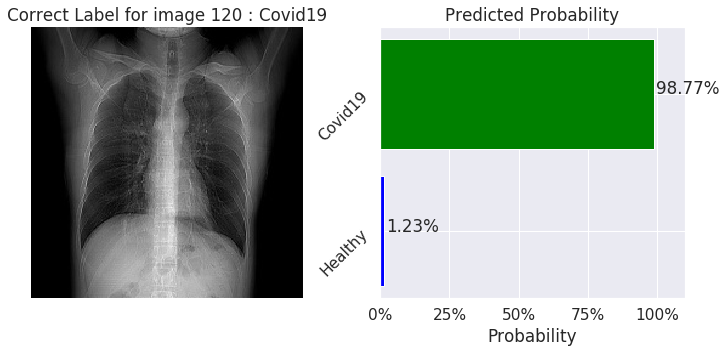

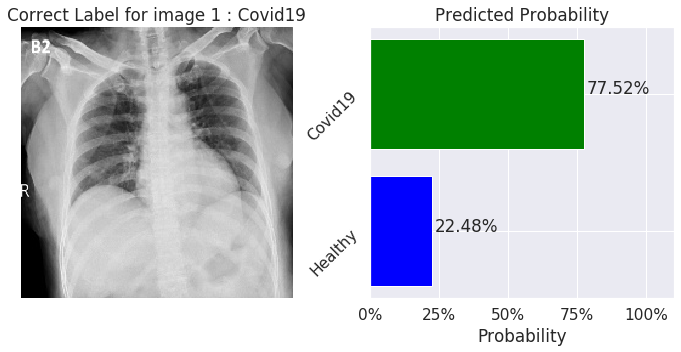

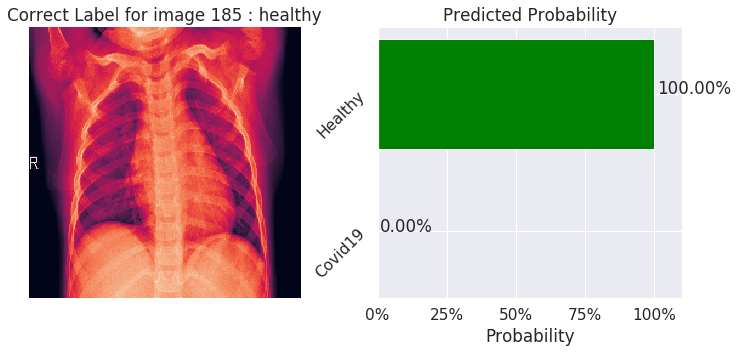

In [20]:
# Some correctly classified images
model.plot_evaluate_res(img_type='C', randomize=True, n_images=5)

Using results from model.predict()
 filtering by filename or _id_ 
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib CASUSER(sas).
NOTE: Table FILTERED_89QX2E contains compressed images.


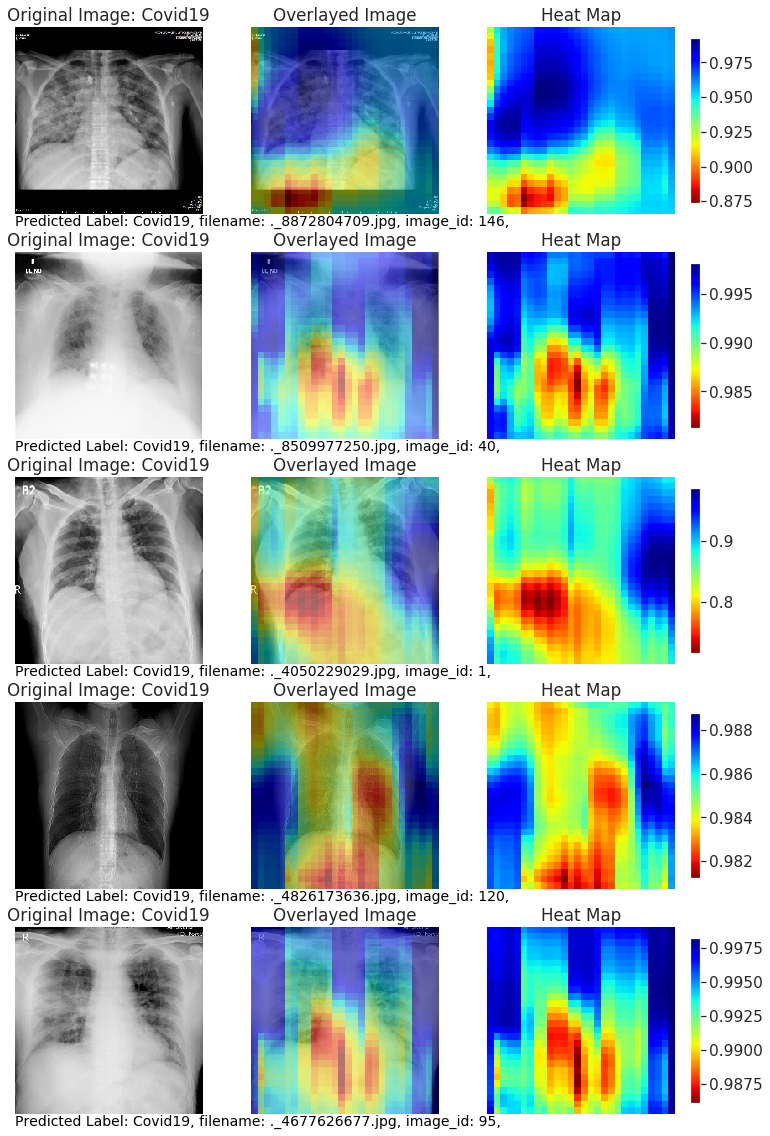

NOTE: Cloud Analytic Services dropped table FILTERED_89QX2E from caslib CASUSER(sas).


_id_       _filename_0                                            _image_  \
0  146  ._8872804709.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1   40  ._8509977250.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2    1  ._4050229029.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  120  ._4826173636.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4   95  ._4677626677.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

   _label_ I__label_                                           heat_map  \
0  Covid19   Covid19  [[0.9252313375473022, 0.9252313375473022, 0.92...   
1  Covid19   Covid19  [[0.9969660639762878, 0.9969660639762878, 0.99...   
2  Covid19   Covid19  [[0.8360354900360107, 0.8360354900360107, 0.83...   
3  Covid19   Covid19  [[0.9838475584983826, 0.9838475584983826, 0.98...   
4  Covid19   Covid19  [[0.9968494772911072, 0.9968494772911072, 0.99...   

   P__label_Covid19  P__label_healthy  
0          0.953355          0.046645  
1          0.998121          0.001879  
2          0.775240          0.224760  
3          0.987678          0.012322  
4          0.998008          0.001992

In [23]:
# Generate Heat Map for true positives on test data aka what is the model looking at?
true_positives = model.valid_res_tbl[(model.valid_res_tbl['_label_'] == model.valid_res_tbl['I__label_']) & (model.valid_res_tbl['_label_'] == 'Covid19')].head()
model.heat_map_analysis(mask_width=56, mask_height=56, step_size=8, max_display=10, image_id=list(true_positives['_id_'].values))

In [22]:
# Save Astore model
model.deploy(path=notebook_path, output_format='astore')

NOTE: Model astore file saved successfully.


# Can we distinguish covid19 from other diseases?

We want to find out whether we can also distinguish different lung diseases.<br>
Therefore we now include images of three other diseases.

In [26]:
disease_list = ['ARDS', 'SARS', 'COVID-19', 'Streptococcus']
all_images = ImageTable.from_table(tbl=covid_joined, image_col='_image_', path_col='filename', columns=list(metadata.columns))
all_images = all_images[(all_images['view'] == 'PA') & (all_images['finding'].isin(disease_list))]
all_images['_label_'] = all_images['finding']

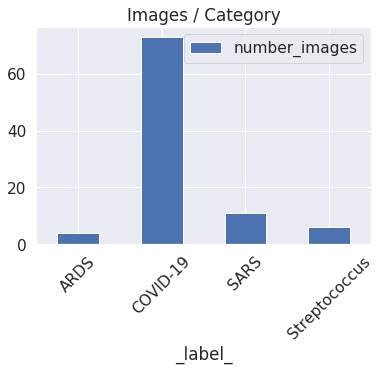

In [27]:
# How many images per category do we have?
plot1 = all_images[['_label_','filename']].groupby(by='_label_').count().reset_index().rename(columns={'filename':'number_images'})
ax = plot1.plot.bar(x='_label_', y='number_images', rot=45, title='Images / Category')

In [28]:
# Sample image tables by Patientid (make sure images from one patient are either train or test, not both)
train_ids = []
test_ids = []
for disease in disease_list:
    _patients = list(set(all_images[all_images['_label_'] == disease]['Patientid'].values))
    _patients_train = sample(_patients, int(len(_patients)*0.9))
    _patients_test = list(set(_patients) - set(_patients_train))
    train_ids.extend(_patients_train)
    test_ids.extend(_patients_test)
train_ids = list(set(train_ids))
test_ids = list(set(test_ids))

all_images_train = all_images[all_images['Patientid'].isin(train_ids)]
all_images_test = all_images[all_images['Patientid'].isin(test_ids)]

In [29]:
s.dljoin(
        annotatedTable = all_images_train,
        table = kaggle_chestxray_train,
        casout = {'name':'all_trainTbl','replace':True},
        id = 'idjoin',
        type = 'append'
    )
all_train = s.CASTable('all_trainTbl')
all_train = ImageTable.from_table(tbl=all_train, columns=list(all_images_train.columns)[4:-1])
s.dljoin(
        annotatedTable = all_images_test,
        table = kaggle_chestxray_test,
        casout = {'name':'all_testTbl','replace':True},
        id = 'idjoin',
        type = 'append'
    )
all_test = s.CASTable('all_testTbl')
all_test = ImageTable.from_table(tbl=all_test, columns=list(all_images_test.columns)[4:-1])

#Resize and shuffle data
all_train.resize(height=224, width=224, columns=list(full_train.columns))
all_train.shuffle(casout=dict(replace=True))
all_test.resize(height=224, width=224, columns=list(full_test.columns))
all_test.shuffle(casout=dict(replace=True))

[caslib]

 'CASUSER(sas)'

[tableName]

 '_T_STJ3HJB5_OAW7VJ22_2KIPP4C6RK'

[casTable]

 CASTable('_T_STJ3HJB5_OAW7VJ22_2KIPP4C6RK', caslib='CASUSER(sas)')

+ Elapsed: 0.00314s, user: 0.00599s, sys: 2.9e-05s, mem: 21.4mb

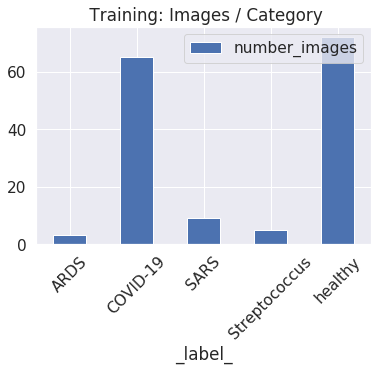

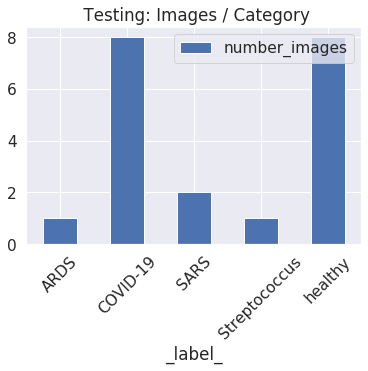

In [30]:
# After splitting: Make sure that there is data of each class in both datasets
plot2 = all_train[['_label_','_image_']].groupby(by='_label_').count().reset_index().rename(columns={'_image_':'number_images'})
ax = plot2.plot.bar(x='_label_', y='number_images', rot=45, title=' Training: Images / Category')
plot3 = all_test[['_label_','_image_']].groupby(by='_label_').count().reset_index().rename(columns={'_image_':'number_images'})
ax = plot3.plot.bar(x='_label_', y='number_images', rot=45, title=' Testing: Images / Category')

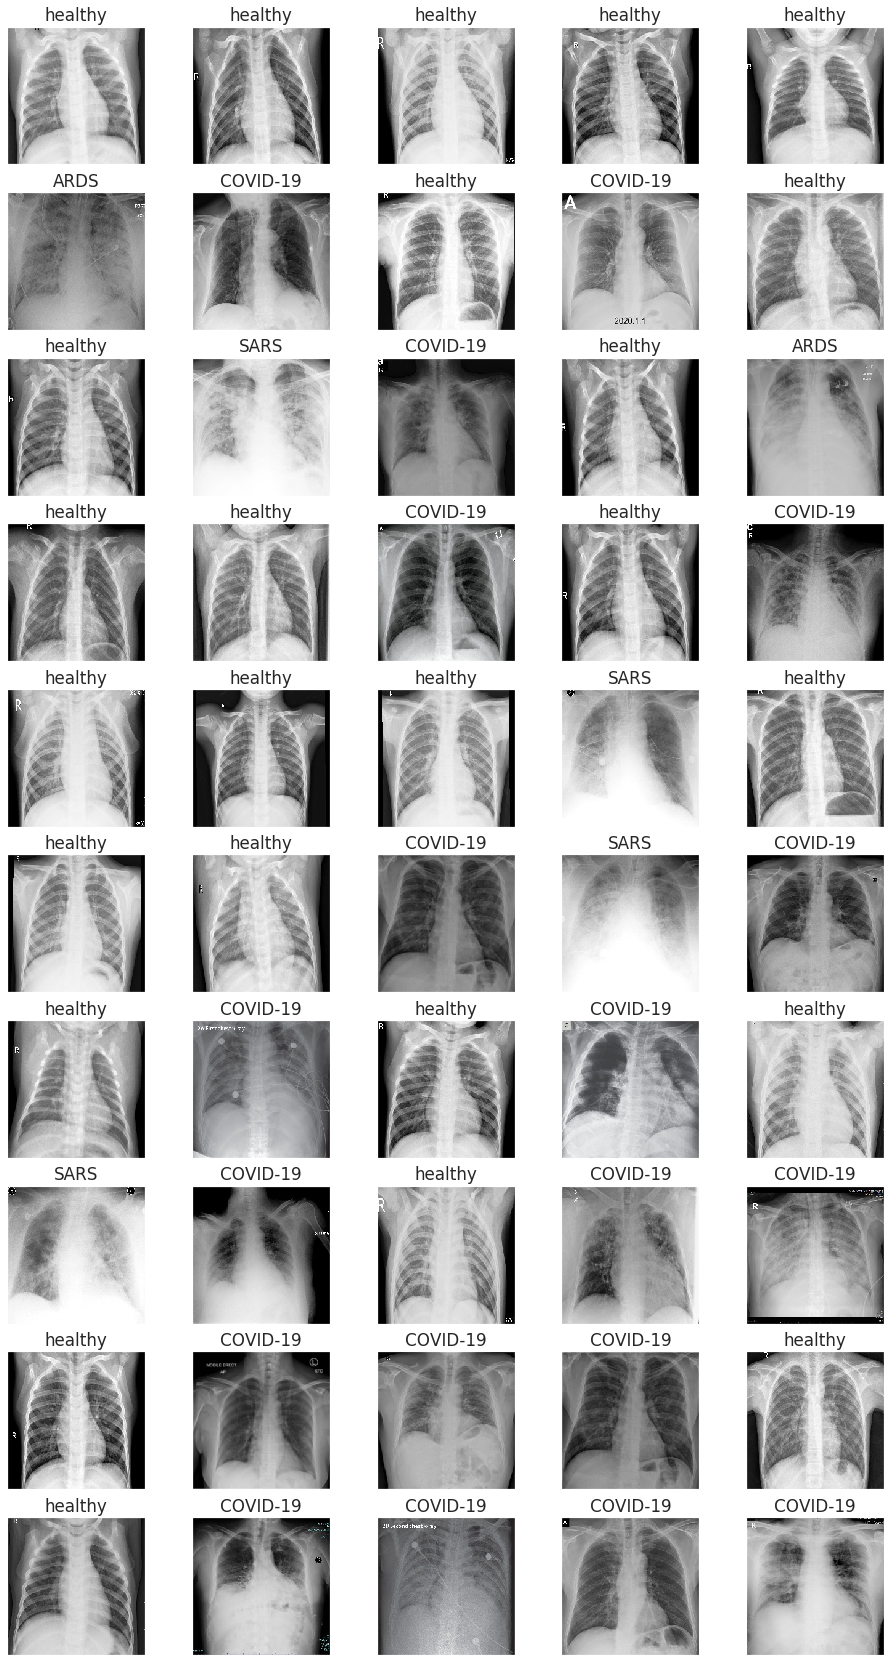

In [33]:
# Finall how does our training set look like?
all_train.show(nimages=50, ncol=5)

In [50]:
# Load Resnet-50 ONNX model with pretrained weights
resnet_onnx_model_path = '/data/notebooks/deep_learning_examples/models/ONNX/resnet50/resnet50v1.onnx'
num_classes = len(set(all_train['_label_'].values))

onnx_model = onnx.load_model(resnet_onnx_model_path)
model = Model.from_onnx_model(s, 
                               onnx_model,
                               output_model_table='resnet50v1_multi',
                               scale=1./255., 
                               offsets=[0.485, 0.456, 0.406])
# Remove last layer and add new layer with 2 classes.
model_table = s.CASTable(model.model_table['name'])
model.load_weights(path='{}/resnet50v1_weights.onnxmodel.h5'.format(notebook_path))
model._retrieve_('deeplearn.removelayer', model=model_table, name='resnetv17_dense0_fwd')
model._retrieve_('deeplearn.addlayer', model=model_table, name='output',
                 layer=dict(type='output', n=num_classes, act='softmax'),
                 srcLayers=['resnetv17_pool1_fwd'])
weight_table_options = model.model_weights.to_table_params()
weight_table_options.update(dict(where='_LayerID_<125'))
model._retrieve_('table.partition', table=weight_table_options,
                 casout=dict(replace=True, **model.model_weights.to_table_params()))
model = Model.from_table(model_table)

NOTE: Successfully written weights file as /data/notebooks/deep_learning_examples/Covid19/resnet50v1_multi_weights.onnxmodel.h5
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1_multi" according to the model name in the table.
NOTE: Successfully imported ONNX model.
NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1_multi" according to the model name in the table.


In [51]:
# Define training-parameters
lr_scheduler = ReduceLROnPlateau(conn=s, 
                                 cool_down_iters=10, 
                                 gamma=0.1, 
                                 learning_rate=0.001, 
                                 patience=15)
solver = MomentumSolver(momentum=0.9, 
                        lr_scheduler=lr_scheduler, 
                        clip_grad_max=100, 
                        clip_grad_min=-100)
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=16, 
                      log_level=2, 
                      max_epochs=100, 
                      reg_l2=0.0005,
                      stagnation=10,
                      bn_src_layer_warnings=False)

gpu = Gpu(devices=[0])

dataspecs=[dict(type='image', layer='data', data=['_image_']),
           dict(type='numnom', layer='output', data=['_label_'])]

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [52]:
# Start Training
model.fit(data=all_train,
          valid_table=all_test,
          optimizer=optimizer,
          data_specs=dataspecs, 
          n_threads=1, 
          record_seed=54321,
          force_equal_padding=True, 
          gpu=gpu,
          save_best_weights=True)

NOTE: Training based on existing weights.
NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 23537157.
NOTE:  The approximate memory cost is 527.00 MB.
NOTE:  Loading weights cost       0.48 (s).
NOTE:  Initializing each layer cost       1.37 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 16.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      5
NOTE:  Levels for the target variable:
NOTE:  Level      0: ARDS         
NOTE:  Level      1: COVID-19     
NOTE:  Level      2: healthy      
NOTE:  Level      3: SARS         
NOTE:  Level      4: Streptococcus
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name              resnet50v1_multi
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                           126
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             1
 5              Number of Convolutional Layers                            53
 6                    Number of Pooling Layers                             2
 7            Number of Fully Connected Layers                             0
 8        Number of Batch Normalization Layers                            53
 9                   Number of Residual Layers                            16
 10                Number of Weight Parameters                      23465152
 11                  Number of Bias Parameters                         72005
 12           Total Number of Model Parameters                      23537157
 13  Approximate Memory Cost for Training (MB)                           527

[OptIterHistory]

     Epoch  LearningRate      Loss  FitError    L2Norm  ValidLoss  ValidError
 0       1        0.0010  1.056394   0.33125  2.955149   1.106848        0.25
 1       2        0.0010  0.529954   0.12500  2.954857   0.908390        0.20
 2       3        0.0010  0.248108   0.06875  2.954424   0.740208        0.25
 3       4        0.0010  0.210832   0.05625  2.953920   0.692680        0.20
 4       5        0.0010  0.203196   0.08750  2.953385   0.949683        0.25
 ..    ...           ...       ...       ...       ...        ...         ...
 95     96        0.0001  0.002472   0.00000  2.906155   0.281519        0.10
 96     97        0.0001  0.009542   0.00000  2.906097   0.287358        0.10
 97     98        0.0001  0.012694   0.00000  2.906039   0.325921        0.15
 98     99        0.0001  0.003032   0.00000  2.905982   0.313676        0.20
 99    100        0.0001  0.001806   0.00000  2.905924   0.259476        0.05
 
 [100 rows x 7 columns]

[OutputCasTables]

          casLib                       Name      Rows  Columns  \
 0  CASUSER(sas)  model_best_weights_keY5EN  23590277        3   
 1  CASUSER(sas)   resnet50v1_multi_weights  23590277        3   
 
                                             casTable  
 0  CASTable('model_best_weights_keY5EN', caslib='...  
 1  CASTable('resnet50v1_multi_weights', caslib='C...  

+ Elapsed: 151s, user: 156s, sys: 1.29s, mem: 566mb

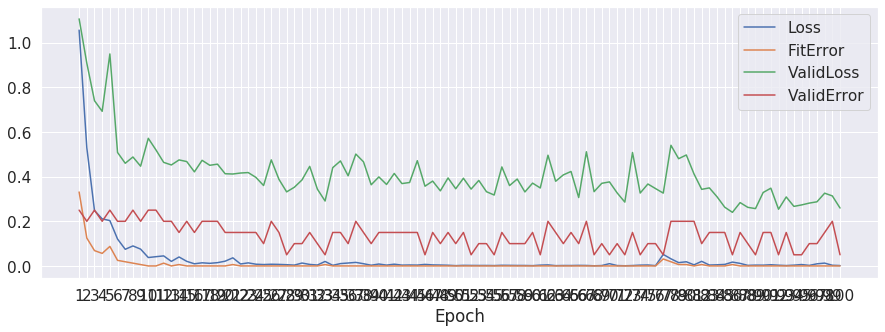

In [53]:
# View Training history
model.plot_training_history(items=['Loss','FitError','ValidLoss','ValidError'], fig_size=(15, 5))

In [54]:
model.evaluate(data=all_test)

NOTE: Due to data distribution, miniBatchSize has been limited to 2.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            20
 1  Number of Observations Used            20
 2  Misclassification Error (%)             5
 3                   Loss Error        0.2595

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_L1UrXR    20       27   
 
                                             casTable  
 0  CASTable('Valid_Res_L1UrXR', caslib='CASUSER(s...  

+ Elapsed: 1.45s, user: 10.4s, sys: 1.42s, mem: 2.87e+03mb

In [55]:
print('Accuracy: {} %'.format(accuracy_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])*100))
print('F1 Score: {}'.format(f1_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'], pos_label=1)))

Accuracy: 95.0 %
F1 Score: 0.9411764705882353


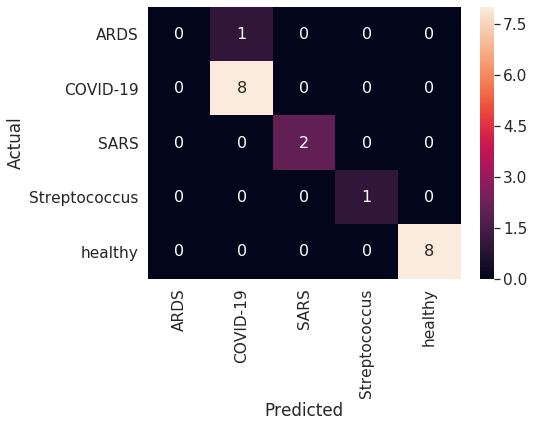

In [56]:
# Confusion Matrix Heatmap
cfm_all = confusion_matrix(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])
cfm_all.index.name = 'Actual'
cfm_all.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)
sn.heatmap(cfm_all, annot=True, annot_kws={'size':16})

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


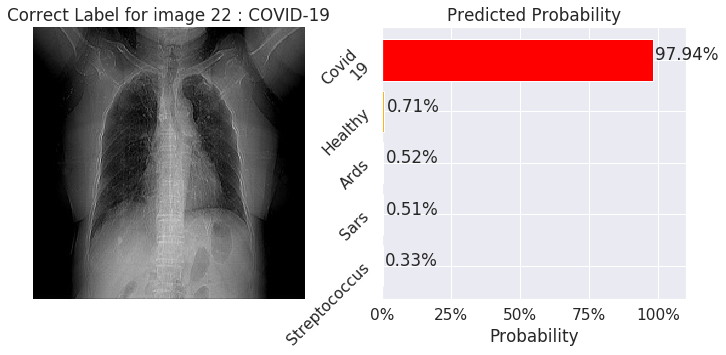

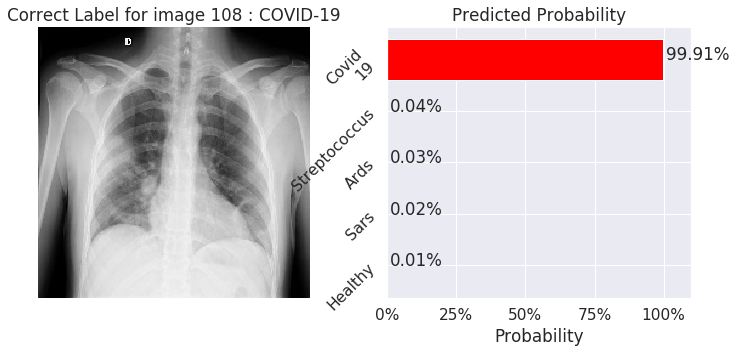

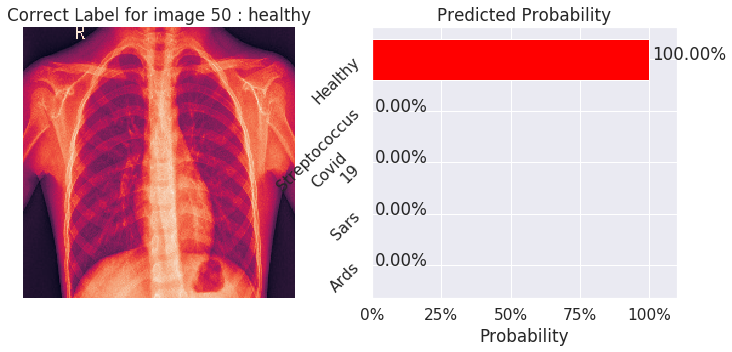

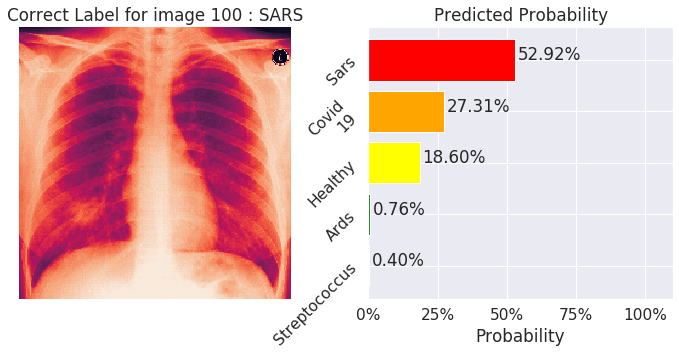

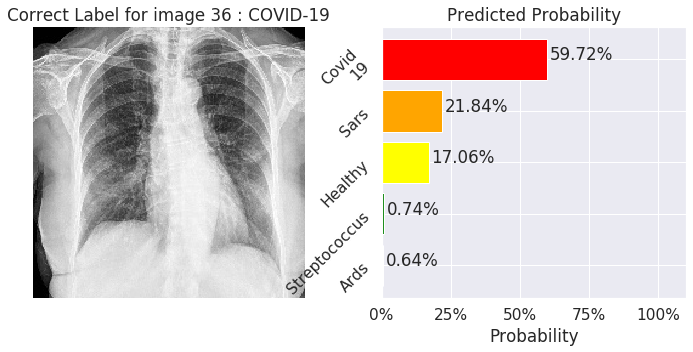

In [57]:
# Some correctly classified images
model.plot_evaluate_res(img_type='C', randomize=True, n_images=5)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


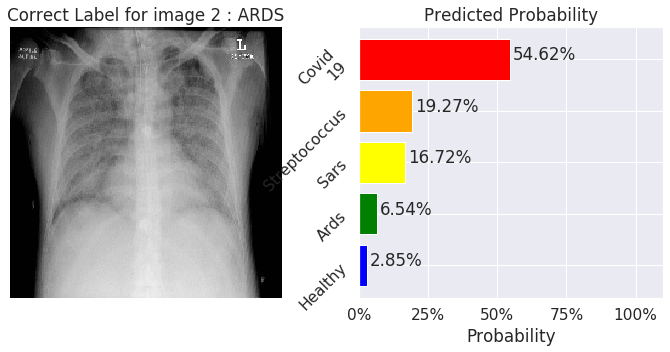

In [58]:
# Some incorrectly classified images
model.plot_evaluate_res(img_type='M', randomize=True, n_images=5)

In [59]:
# Save Astore model
model.deploy(path=notebook_path, output_format='astore')

NOTE: Model astore file saved successfully.


# Future ideas
- Scrape more images for better training & evaluation
- Add mutations to our data to create more images of underpresented classes
- Try different models (Inception, larger ResNets, etc.)
- Include metadata into models (age, gender, etc.)
- Deploy models and provide convenient way of scoring (e.g. via a website)